  # Machine Learning Notebook
  ## EDA

 Lets load the frontpage data of 4 years going from december 22. 2019 to december 22. 2023.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/4yrs_derstandard_frontpage_data.csv')

# prepare time data
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,title,subtitle,link,datetime,kicker,n_posts,storylabels
0,Real Madrid stolpert mit Aluminiumpech im Tite...,Die Königlichen können Bilbao daheim nicht bes...,https://www.derstandard.at/story/2000112599363...,2019-12-22 23:44:00,Primera Division,30,NaN
1,Bolivien weist venezolanische Diplomaten aus,InterimspräsidentinJeanine Áñez wirft denBotsc...,https://www.derstandard.at/story/2000112598924...,2019-12-22 22:50:00,Übergangsregierung,16,NaN
2,Erdoğan warnt vor neuer Flüchtlingswelle aus S...,"Türkischer Präsident: ""80.000 Menschen Richtun...",https://www.derstandard.at/story/2000112598130...,2019-12-22 21:43:00,Bürgerkrieg,104,NaN
3,Massenkarambolage mit 63 Fahrzeugen in Virginia,Autos stießen auf vereister Brücke zusammen,https://www.derstandard.at/story/2000112597972...,2019-12-22 21:29:00,Weihnachtsverkehr,35,NaN
4,"Salzburg schlägt Caps, Meister KAC mit vierter...",Die Bullen sind damit der Gewinner der Runde: ...,https://www.derstandard.at/story/2000112595206...,2019-12-22 20:54:00,Eishockey,4,NaN


 182 thousand rows, lets inspect the data a bit

In [2]:
print('All variables:\n', df.dtypes, '\n')
print('N_posts percentiles:\n', df['n_posts'].describe(), '\n')
print('n_posts 0-values:\n', len(df[df['n_posts']==0]))

All variables:
 title                  object
subtitle               object
link                   object
datetime       datetime64[ns]
kicker                 object
n_posts                 int64
storylabels            object
dtype: object 

N_posts percentiles:
 count    1.821070e+05
mean     3.342677e+02
std      7.621049e+03
min      0.000000e+00
25%      1.400000e+01
50%      7.200000e+01
75%      2.490000e+02
max      3.000166e+06
Name: n_posts, dtype: float64 

n_posts 0-values:
 10417


 ### Data correctness
 While manually analyzing a sample of the over 10.000 articles with 0 posts, We noticed that there were a lot of articles that generated 0 posts. In the scraping script, we gathered the post count in the function `extract_article_data()`, which searched for the span containing the post count. Sometimes 0 posts is explicitely mentioned, sometimes the span is empty.

 We analyzed a sample our data on articles with 0 posts and found that the information we could get from the frontpage seems to be correct and that the articles with 0 posts did indeed generate 0 posts. With one exception - the data on Live tickers was sometimes incorrect and indicated 0 posts when there were many posts in actuality.

 The cause for this mismatch is unclear to us, but we were able to find a pattern which helps us find those wrongly labeled discussion forums.

In [3]:
print('posts which contain ticker in the title:')
print(df[df['title'].str.contains('Ticker')]['storylabels'].value_counts(dropna=False), '\n')
print('posts which contain live in the title:')
print(df[df['title'].str.contains('Live')]['storylabels'].value_counts(dropna=False), '\n')


posts which contain ticker in the title:
storylabels
NachleseLiveticker     271
LivetickerNachlese      30
LiveLiveticker           6
NaN                      6
NachleseLivebericht      5
Forum+Nachlese           3
LivetickerLive           2
LiveberichtNachlese      2
NachleseForum+           1
LiveForum+               1
LiveLivebericht          1
Forum+Live               1
Name: count, dtype: int64 

posts which contain live in the title:


storylabels
NaN                    502
NachleseLiveticker      64
NachleseLivebericht     12
LivetickerNachlese       9
Kolumne                  7
Interview                5
LiveberichtNachlese      4
Video                    3
Analyse                  3
Blog                     3
Podcast                  2
Porträt                  2
Bericht                  2
Ansichtssache            2
Essay                    1
LiveLiveticker           1
Kopf des Tages           1
Kommentar                1
KolumneVideo             1
LivetickerLive           1
Rezension                1
Reportage                1
Name: count, dtype: int64 



 While there are still some NA values in the set of posts that contain the words Live or Ticker, closer inspection has shown that those articles were not actually discussion forums/live tickers but rather articles like `Livestreams, Ticker und Spielpläne: Wie man die EM 2021 online verfolgt`.

 But as it turns out, livetickers seem to be among the rare data points that have all been assigned a storylabel. We will thus first identify the storylabels that live articles have been tagged with.

In [4]:
# all the Live storylabels (I checked, they are all capitalized)
live_labels = df[(df['storylabels'].str.contains('Live')) & (~df['storylabels'].isna())]['storylabels'].value_counts()
live_labels = list(live_labels.index)
print('All Live storylabels:\n*', '\n* '.join(live_labels))


All Live storylabels:
* NachleseLivebericht
* NachleseLiveticker
* LiveberichtNachlese
* LivetickerNachlese
* LiveForum+
* LiveLiveticker
* Forum+Live
* LiveLivebericht
* LivetickerLive
* LiveberichtLive
* LiveberichtVorschau
* VorschauLiveticker
* Liveticker
* LiveberichtVideo
* Livebericht


 We will now use this list of storylabels and simply drop all articles tagged with them that contain 0 posts. Of course this approach is just a heuristic and there is a very good chance there are still wrongly labeled datapoints, but for the purposes of this project we will leave it at that. Those >900 articles are very likely to be wrongly labeled, and making another request to fetch the actual comment count would be too time-consuming for the purposes of this project.

In [5]:
forums = df[df['storylabels'].isin(live_labels)]
no_post_forums = forums[forums['n_posts'] == 0]
print(f'Forums wrongly labeled as 0 posts: {len(no_post_forums)} out of {len(forums)}')

# drop all rows from the df that are in no_post_forums
df.drop(no_post_forums.index, inplace=True)
print(f'Dropped {len(no_post_forums)} rows. {len(df)} rows remaining.')



Forums wrongly labeled as 0 posts: 907 out of 2422
Dropped 907 rows. 181200 rows remaining.


 ### Post count distribution
 Next we will look at the distribution of our intended target variable, `n_posts`. For a first look, we bin the articles in ranges of 10. The following scatterplot shows the number of articles that generate between n and n+10 posts on the y axis and the lower bound of the bin (n) of posts on the x-axis.

Text(0, 0.5, 'Frequency')

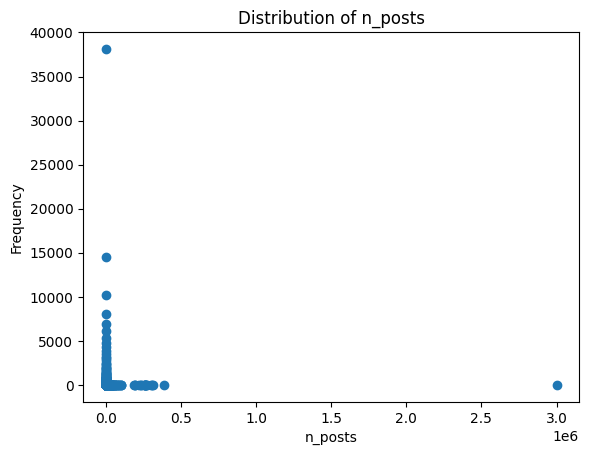

In [6]:
# print n_posts distribution
max_posts = np.ceil(df['n_posts'].max() / 10) * 10 # rounded to nearest multiple of 10
bins = np.arange(0, max_posts + 10, 10) # steps of 10
binned_table = df.groupby(pd.cut(df['n_posts'], bins, include_lowest=True), observed=False).size().reset_index(name='counts')

binned_table = binned_table[binned_table['counts'] != 0]
binned_table['bin_middle'] = binned_table['n_posts'].apply(lambda x: x.mid)

# Scatterplot of table
plot = plt.scatter(binned_table['bin_middle'], binned_table['counts'])
plt.title('Distribution of n_posts')
plt.xlabel('n_posts')
plt.ylabel('Frequency')


 This is a very zoomed out look. Before we focus this scatterplot, we'll check out the outlier that generated 3 million posts:

In [7]:
print('Articles with the most posts')
print(df.sort_values(by='n_posts', ascending=False)[['title', 'n_posts']].head(10))

Articles with the most posts
                                                   title  n_posts
108017                 Off-Topic-Ticker mit TickerOfLove  3000166
108018  Off-Topic-Ticker mit Ticker of Love and Laughter   389259
102886                          Seuchenticker-Basislager   314567
109509                        Seuchenticker-Basislager 3   308522
170225                              Ticker-Basislager 13   300140
149054                     (Seuchen)ticker-Basislager 10   275232
135239                        Seuchenticker-Basislager 7   270924
115763                        Seuchenticker-Basislager 4   268672
157329                              Ticker-Basislager 11   263017
149052                        Seuchenticker-Basislager 9   262740


 It is the love forum that generated 3 million posts, after that, the next post also deals with topics of love but has 400 thousand posts. The rest of the top 10 seem to also all be forum posts. Lets visualize the relative share of the different storylabels when the post count increases (keeping in mind that only a minority of posts has a storylabel):

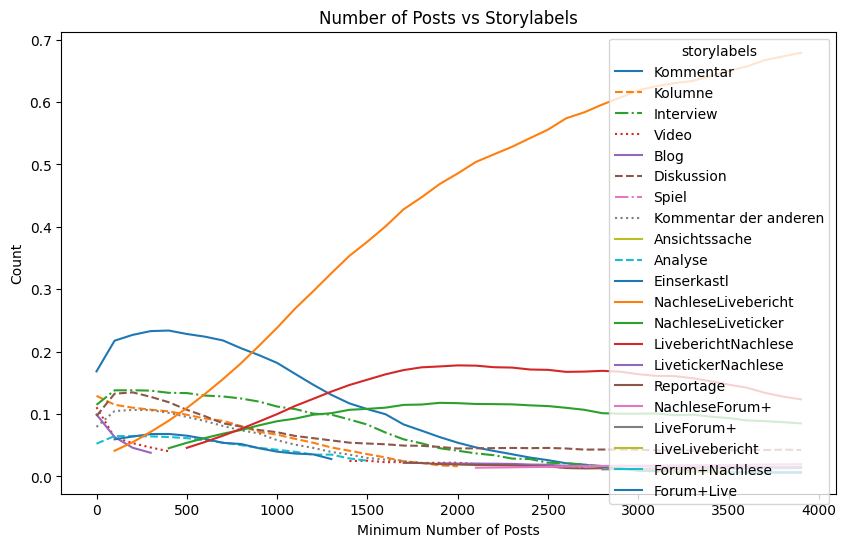

In [8]:
r = range(0, 4_000, 100)
label_tracker = []
for min_posts in r:
    d = df[df['n_posts'] > min_posts].storylabels.value_counts()[:10]
    label_tracker.append(d / d.sum())

df_label_tracker = pd.concat(label_tracker, axis=1).T
df_label_tracker.reset_index(drop=True, inplace=True)
df_label_tracker['min_posts'] = r
df_label_tracker.set_index('min_posts', inplace=True)
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
df_label_tracker.plot(kind='line', style=styles, figsize=(10, 6))

plt.title('Number of Posts vs Storylabels')
plt.xlabel('Minimum Number of Posts')
plt.ylabel('Count')
plt.show()



 We can see that the relative share of articles with tagged with forum associated story labels increases above 1.500 posts. If we also plot the na, values, we can see them actually becoming the minority above ~2.700 posts, but we left out those Na in order to better illustrate the relative share of other storylabels decreasing relative to Liveposts.

 But lets return to the distribution of posts and focus the scatterplot a bit. This time we will omit posts within the 0-10 range as that bucket dwarfs the scale of the following buckets (we're avoiding a log scale for now). We'll also only plot the buckets up to 3.000 posts:

Text(0, 0.5, 'Frequency')

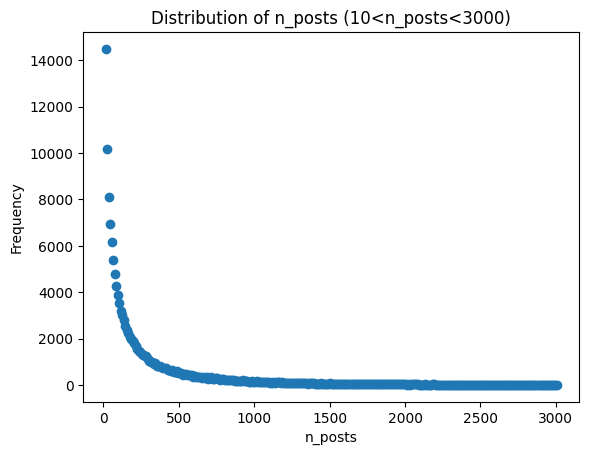

In [9]:
plt.scatter(binned_table['bin_middle'][1:301], binned_table['counts'][1:301])
plt.title('Distribution of n_posts (10<n_posts<3000)')
plt.xlabel('n_posts')
plt.ylabel('Frequency')



 The distribution of posts seems to exhibit a power law distribution. The curve very beautifully follows some logarithmic function.

 As seen in the first distribution plot, the distribution has an extremely long tail that gradually thins out. The 3million ticker is a very strong outlier here, but even up to 400 thousand posts there are still a few articles in our large data set. Before we decide on a strategy on how to deal with those, lets check out the boxplot:

Five-point summary:
 count    1.812000e+05
mean     3.359409e+02
std      7.640062e+03
min      0.000000e+00
25%      1.500000e+01
50%      7.300000e+01
75%      2.510000e+02
max      3.000166e+06
Name: n_posts, dtype: float64 

Increasingly smaller buckets:
 0.2500        15.000000
0.5000        73.000000
0.7500       251.000000
0.9000       637.000000
0.9500      1047.000000
0.9900      2751.020000
0.9990     20050.811000
0.9999    181071.088898
Name: n_posts, dtype: float64 



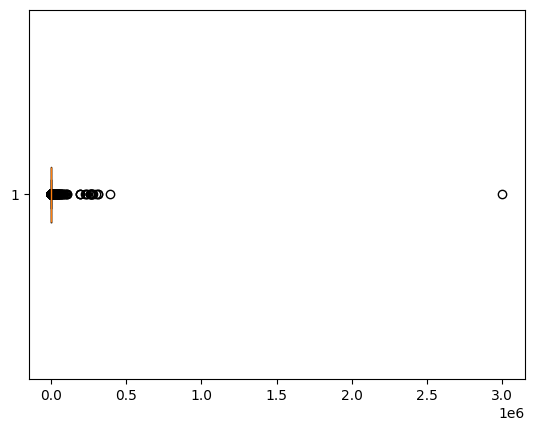

In [10]:
plt.boxplot(df['n_posts'], vert=False, )
print('Five-point summary:\n', df['n_posts'].describe(), '\n')
print('Increasingly smaller buckets:\n', df['n_posts'].quantile([.25, .5, .75, .9, .95, .99, .999, .9999]), '\n')

 This again confirms that there is a very long tail. For the purposes of our machine learning project, we have to consider how we'll deal with this long stretch. Initally the idea was to produce a regression neural network, with a single output neuron that would output continuous values. In this case, the outliers would have caused much trouble with scaling the data and we would have probably trimmed our dataset above a certain percentile-based threshold e.g. 99.99%.

 We decided to simplify our regression problem by using (roughly) equally sized bins which are still an ordinal variable so we can still perform a regression without loosing the valuable information for the gradient of how wrong a given prediction is. I.e. instead of just using categories, we can still perform regression over those bins and tell the network in our loss function how far a predicted bin is from the actual bin. Those bins should cover meaningful ranges in the number of posts, reflecting the logarithmic distribution of posts.

 For this we use the qcut pandas function. This function however throws an error if the bins are not equally sized. Because there are so many articles with 0 posts (5% of our data), it will be impossible to make a bin that contains 1 % of the data withing those bounds. Similarly the articles with 1 post are also a bin that would be larger than the other bins. Thus we:

 1. create a special bin for all articles with 0 posts
 2. we set the `duplicates=drop` kwarg which allows for uneven sized bins (it will drop overlapping buckets)

Considering the power-law distribution of our data, it is inevitable that the first buckets consist of very small ranges. Even with manually assigning 0-posts to their own bucket, the first set of buckets are actually also just single-value (e.g. '2', '3') ranges with a disproportionally large number of observations in them. For training purposes it of course would be good if all our bins are equally sized - but maybe it is also important to make the network good at spotting unsucessful posts.

First we tried 100 buckets but saw that the qcut function dropped a lot of buckets. Thus we decided for a smaller number of buckets that could still meaningfully disect the data and just went with 64 buckets because it's a nice number. Furthermore you will notice that q is set to 65, because there are 2 overlapping buckets which will be dropped.

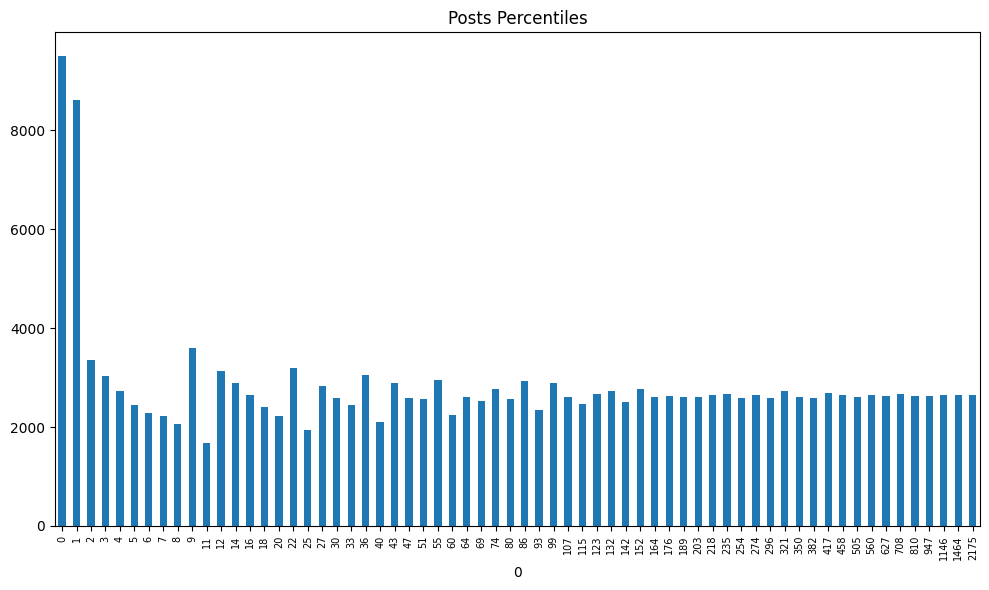

There are 64 buckets


In [39]:
nonzero = df['n_posts'] > 0

# Apply qcut to these rows and convert the result to string
df.loc[nonzero, 'n_posts_percentile'] = pd.qcut(df.loc[nonzero, 'n_posts'], q=65, 
                                             duplicates='drop').astype(str)

# Set the 0 posts to '0'
df.loc[df['n_posts'] == 0, 'n_posts_percentile'] = '(0.0, 1.0]'

# extract the lower bound of the bins and convert to float
float_pattern = r'\d+\.\d+'
bounds = df['n_posts_percentile'].value_counts().index.str.extract(
    f'({float_pattern}), ({float_pattern})').astype(float)
bounds = bounds.round().astype(int)

s = pd.Series(df['n_posts_percentile'].value_counts().values, index=bounds[0])
s.sort_index().plot(kind='bar', figsize=(10, 6))
plt.xticks(fontsize=7) 
plt.title('Posts Percentiles')
plt.tight_layout()
plt.show()
print(f'There are {len(df['n_posts_percentile'].value_counts())} buckets')


The first set of buckets turn out to just be the range from 0 to 12, and we can see that the 0 and 1 buckets are both very large bins. We can also see that our percentiles cut off at around 2.100 posts, after which the long tail begins. Compared to the initial distribution plots though, we have mostly flattened the curve. 

To produce the final target variable, we map those buckets to the range from 0 to 63. We won't transform this data any further as we hope that a sufficiently large network will be able to cope with that range without centering the values as well. As the buckets are roughly evenly distributed now (save for 0 and 1), we will not normalize our data.

In [42]:
target_map = pd.DataFrame({
    'lower_b': bounds[0],
    'upper_b': bounds[1],
    'bounds': df['n_posts_percentile'].value_counts().index
})

target_map.sort_values(by='lower_b', inplace=True)
target_map.reset_index(drop=True, inplace=True)

# Map 'n_posts_percentile' to 'bounds' and assign the index of the matching row to 'target'
df['target'] = df['n_posts_percentile'].map(target_map.reset_index().set_index('bounds')['index'])
# save the target map
target_map.to_csv('./data/target_map.csv', index=False)
target_map


,lower_b,upper_b,bounds
0,0,1,"(0.0, 1.0]"
1,1,2,"(0.999, 2.0]"
2,2,3,"(2.0, 3.0]"
3,3,4,"(3.0, 4.0]"
4,4,5,"(4.0, 5.0]"
...,...,...,...
59,810,947,"(810.0, 947.0]"
60,947,1146,"(947.0, 1146.0]"
61,1146,1464,"(1146.0, 1464.0]"
62,1464,2175,"(1464.0, 2175.0]"


 ### Time series analysis
 First, lets' plot the number of articles on the frontpage per day

<Axes: xlabel='datetime'>

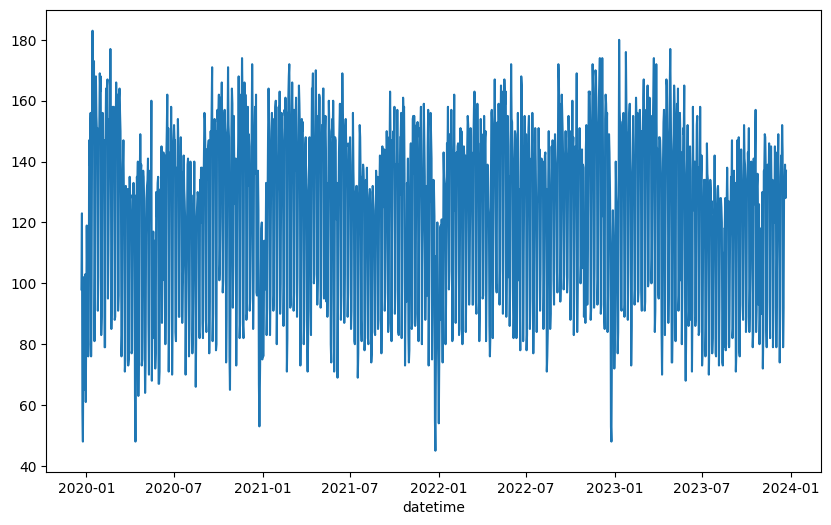

In [13]:
df.groupby(df['datetime'].dt.date).count()['title'].plot(figsize=(10, 6))


 Too many fluctuations, let's look at the rolling 30 day average

<Axes: xlabel='datetime'>

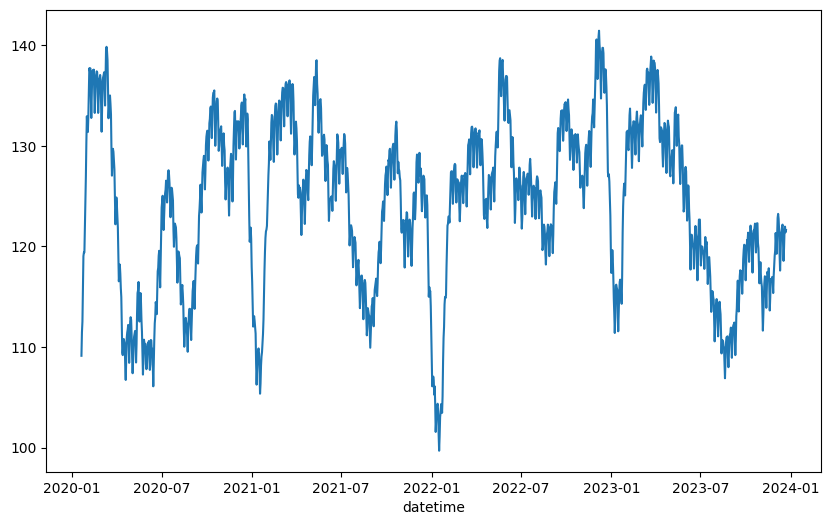

In [14]:
df.groupby(df['datetime'].dt.date).count()['title'].rolling(30).mean().plot(figsize=(10, 6))

 The number of articles per day does seem to follow some seasonal trends
 Maybe at the end of the year the number of articles drops, as well as during the summer months due to the Sommerloch. Let's investigate this by aggregating the number of articles by month


<Axes: xlabel='month'>

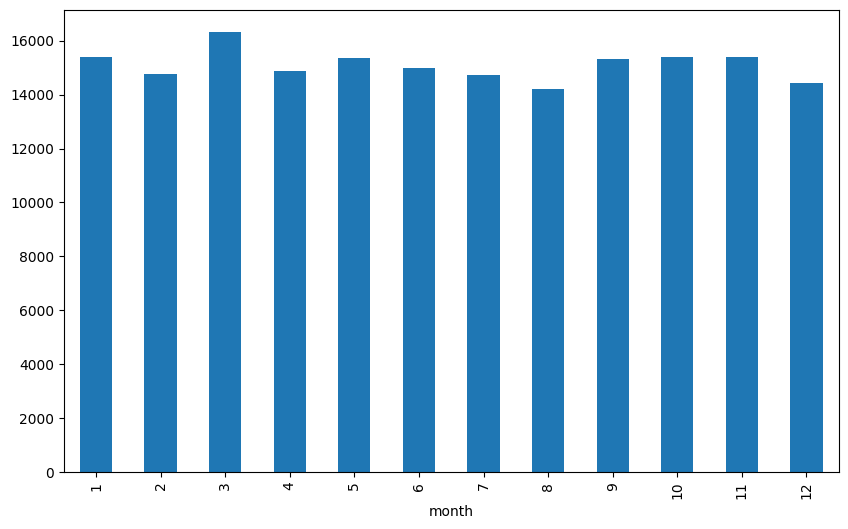

In [15]:
df['month'] = df['datetime'].dt.month
df.groupby('month').count()['title'].plot(kind='bar', figsize=(10, 6))


 Well, that rejects that hypotheses, the articles seem to even out over 4 years by month.

 Next, lets add a weekday column to our data

<module 'matplotlib.pyplot' from 'c:\\Users\\Paul\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

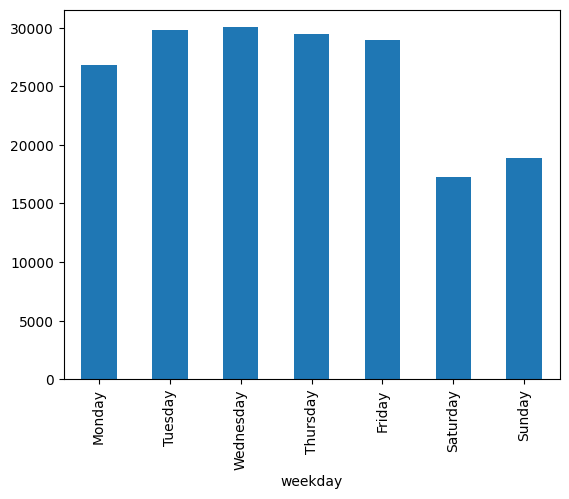

In [16]:
df['weekday'] = df['datetime'].dt.weekday
df.groupby('weekday').count()['title'].plot.bar()
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt


 less datapoints for the weekends it seems. We will make use of this weekday variable in our predictions as well.

 We'll also add a time of day column and plot this.

<Axes: xlabel='hour'>

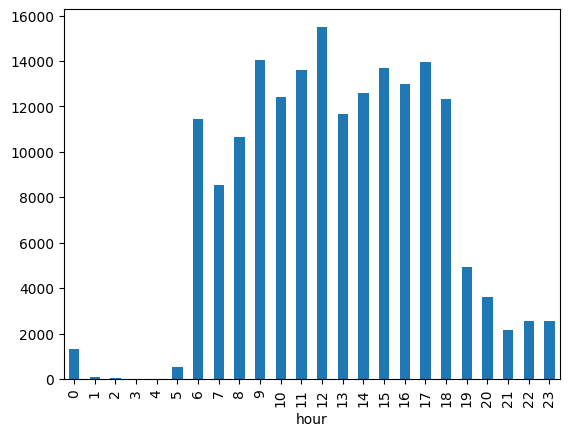

In [17]:
# add a hour column
df['hour'] = df['datetime'].dt.hour
# which hour has the most articles?
df.groupby('hour').count()['title'].plot.bar()


 Most articles are posted during the day from 6am to 6pm. Continuosly adding new articles during the day probably helps engagement as well.

 ### Label analysis
 We already mentioned in the scraping functions that most articles seem to lack storylabels, but let's investigate this a bit more.

In [18]:
label_counts = df['storylabels'].value_counts(dropna=False)
print(label_counts)
print(f'\nPercentage of articles with a story label: {100-(label_counts.iloc[0]/len(df)) * 100:.2f}%')


storylabels
NaN                 143784
Kommentar             4694
Kolumne               3608
Video                 3238
Interview             3199
                     ...  
Liveticker               1
Userkommentar            1
FeatureReportage         1
Photoblog                1
Forum+Vorschau           1
Name: count, Length: 77, dtype: int64

Percentage of articles with a story label: 20.65%


 only around 20% of articles are labeled. We will not use those labels for our prediction but they were useful for filtering out Ticker posts before. As mentioned, it would also be an interesting labelling task to find labels for the remaining 80% but for now we will focus on the n_posts variable.

 Next we will not look at the number of posts a given label is going to generate, just at which are the most common storylabels.

<Axes: xlabel='storylabels'>

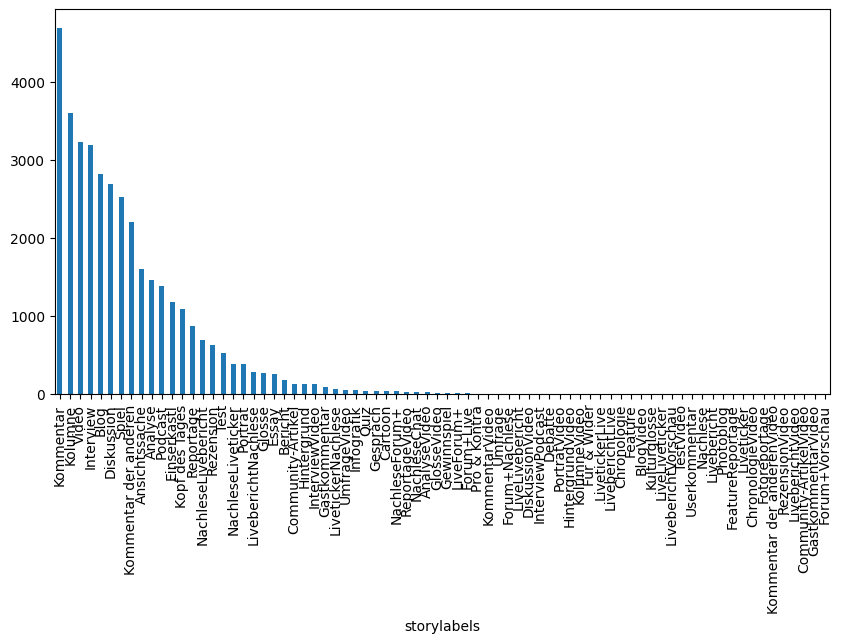

In [19]:
# Plot the number of articles per story label
plt.figure(figsize=(10, 5))
df['storylabels'].value_counts().plot.bar()

 This time the Ticker labels are further behind the distibution, the list being headed by periodicals like Kommentar, Kolumne etc.

 Lastly, lets look at the kicker labels, for which there are no na values.

In [20]:
kickers = df['kicker'].value_counts(dropna=False)
print(f'Number of unique kicker labels: {len(kickers)}\n')
print(f'Most common kicker labels:\n{kickers[:20]}\n')

print(f'There are only {df['kicker'].isna().sum()} na kickers, lets drop them')
# drop kicker na values
df.dropna(subset=['kicker'], inplace=True)

Number of unique kicker labels: 44720

Most common kicker labels:
kicker
Fußball                 3133
Nachrichtenüberblick    3099
Netzpolitik             2674
Sudoku                  2414
Bundesliga              1711
Sport                   1651
USA                     1515
IT-Business             1464
Coronavirus             1375
Games                   1356
Tennis                  1244
Switchlist              1208
Krieg in der Ukraine    1203
Deutsche Bundesliga     1180
Etat-Überblick          1161
Hans Rauscher           1153
Wintersport             1123
TV-Tagebuch             1080
Eishockey               1058
Thema des Tages         1032
Name: count, dtype: int64

There are only 84 na kickers, lets drop them


Those also are dominated by periodicals like Fußball, Nachrichtenüberlick (daily summary of posted articles) etc.

The title along with the subtitle will be our most important predictors. In the following codecell, we concatenate those into a long string along with the kicker-label. We will later use embeddings to encode those strings as numeric vectors.

First, let's plot the distribution of string lengths.

Example of concatted string:
 Real Madrid stolpert mit Aluminiumpech im TitelrennenPrimera DivisionDie Königlichen können Bilbao daheim nicht besiegen 


Shortest titles:
 Sudoku mittel 4493aSudoku
Sudoku mittel 4497aSudoku
Sudoku mittel 4503aSudoku

Mean title length: 195.88 characters
Standard deviation: 47.80 characters
Median title length: 201.00 characters


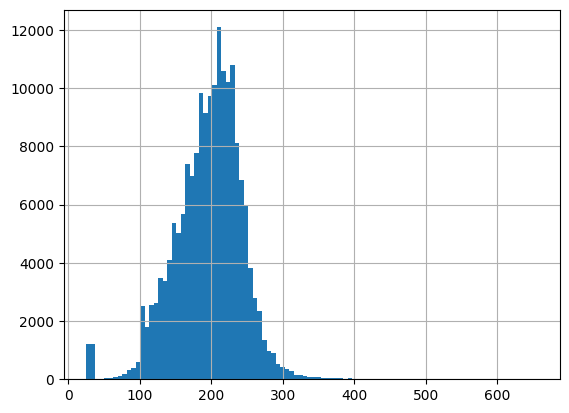

In [21]:
df['text'] = df['title'] +  df['kicker'].fillna('') + df['subtitle'].fillna('')

print('Example of concatted string:\n', df['text'][0], '\n')
df['text'].str.len().hist(bins=100)
short_txt = df['text'].apply(len).nsmallest(3).index.map(df['text']).tolist()
print('\nShortest titles:\n', '\n'.join(list(short_txt)))

print(f'\nMean title length: {df["text"].str.len().mean():.2f} characters')
print(f'Standard deviation: {df["text"].str.len().std():.2f} characters')
print(f'Median title length: {df["text"].str.len().median():.2f} characters')
 

Again a distribution with a long tail that thins out very gradually. During our nlp processing, we will generate vectors of uniform length - thus there is no need to trim our texts.

The first large bin are the sudokus - short texts of roughly the same length. We will also keep them as they are also a part of the frontpage

## Vectorizing our features
As inputs for our network, we need numeric values. The datetime information is already basically numeric, but the text will need some processing.

### Text Processing

For the following steps, we will be using the spacy library which will help us with all the lemmatization and tokenization we need to turn our strings into tokens. We will also be using the german 'news' (large) pipeline, available [here](https://spacy.io/models/de#de_core_news_lg) - Warning, it is 500mb of size.
Its vocabulary consists of many newspaper headlines, so it should be perfect for our application. It also has embedding vectors for a large vocabulary (more on that in the next cell).

In case you want to run this locally, it can be installed using `python -m spacy download de_core_news_md`.

In [37]:
import spacy

# nlp = spacy.load("de_core_news_md")
nlp = spacy.load("de_core_news_lg")

print("Pipeline Components:\n", ", ".join([n for n, p in nlp.pipeline]))

Pipeline Components:
 tok2vec, tagger, morphologizer, parser, lemmatizer, attribute_ruler, ner


### Generating document vectors

This step will add a new column  `spacy_vector`, which contains the mean of all token vectors of a document (headline+subtitle+tags) generated by the embeddings of the spacy model. Spacy uses *Word2VecEmbeddings*, which encodes semantic meaning based on the word's contextual use in the `de_core_news` dataset.

These document vectors provide a numerical representation of our headlines, while still retaining information and at the same time producing vectors of uniform size.


In [38]:
from tqdm import tqdm
tqdm.pandas() # for progress_apply

def process_text(text):
    doc = nlp(text)
    return doc.vector

df['doc_vector'] = df['text'].progress_apply(process_text)

100%|██████████| 181116/181116 [33:23<00:00, 90.38it/s] 


In case we want to work with the information of our model again, we save our nlp object as well.

In [39]:
print('The vectors are of length ', df['doc_vector'][0].shape)
print('The vectors are of type', df['doc_vector'][0].dtype)
print('\n', df['doc_vector'].head())

The vectors are of length  (300,)
The vectors are of type float32

 0    [0.13968499, -0.03319593, -0.6930465, 0.525887...
1    [-0.020349026, 1.012819, -0.6995058, 0.0319790...
2    [0.35490817, -0.4040163, -0.6899125, 0.5971721...
3    [-0.19645023, -0.59209454, -1.2560344, -0.9697...
4    [0.1336856, -0.268013, -0.5303245, -1.3577175,...
Name: doc_vector, dtype: object


We will finally create our inputs column which also contains the month, weekday and hour. We think this information might be useful, e.g. if certain stories are posted in the summer months/ winter, if it is a particular day of the week, if it was posted in the morning or evening. We omit the year to limit overfitting, as well as it's limited usefulness when we consider that those headlines are newsstories and we now have 2024.

We will also normalize those date vectors which means their elements should be roughly the same size as the elements of the document vectors.

In [40]:
import numpy as np

def process_row(row):
    date_vector = np.array([
        row['datetime'].month,
        row['datetime'].weekday(),
        row['datetime'].hour
        ])
    # Normalize the date_vector, ensure it is float32 like the doc vectors
    norm_date_vector = (date_vector / np.linalg.norm(date_vector)).astype(np.float32)
    return np.concatenate((norm_date_vector, row['doc_vector']))

df['inputs'] = df.apply(process_row, axis=1)

print(f'Sequence length: {len(df['inputs'][0])}')


Sequence length: 303


### Saving to parquet
The data processing is thus completed.
We will save our data using the parquet file format which not only handles dtypes like lists natively, it is also a binary format that is much more efficient at storing all our data. You will need to install `pyarrow` if you want to run this yourself.

In [41]:
df[['inputs', 'target', 'n_posts']].to_parquet('data/ml_data.parquet', index=False)
